# PCA

Let's import needed libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier

In [2]:
# %load tools.py
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)).T, cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

Define constants

In [3]:
h = 46
w = 56
IMG_SHAPE = (h,w)
TEST_RATIO = 0.2
FACE_PATH = 'face.mat'

Load the dataset and split it into training and testing sets

In [4]:
mat_content = sio.loadmat(FACE_PATH)
face_data = np.transpose(mat_content['X'])
class_data = np.transpose(mat_content['l'])

X_train, X_test, y_train, y_test = train_test_split(face_data, class_data, test_size=TEST_RATIO, stratify=class_data)
y_train = y_train.ravel()
y_test = y_test.ravel()

# Test stratify :
# unique, counts = np.unique(y_train, return_counts=True)
# print(dict(zip(unique, counts)))

print("Dataset shape : ", face_data.shape)
print("Training dataset shape : ", X_train.shape)
print("Testing dataset shape : ", X_test.shape)
print("Training tag shape : ", y_train.shape)
print("Test tag shape : ", y_test.shape)

Dataset shape :  (520, 2576)
Training dataset shape :  (416, 2576)
Testing dataset shape :  (104, 2576)
Training tag shape :  (416,)
Test tag shape :  (104,)


# PCA-LDA Ensemble with low randomness (i.e. PCA and LDA computed globaly)

In [61]:
pipe = Pipeline([
    ('reduce_dim_PCA', PCA()),
    ('reduce_dim_LDA', LinearDiscriminantAnalysis()),
    ('classify', BaggingClassifier())
])

N_FEATURES_OPTIONS_PCA = [150]
N_FEATURES_OPTIONS_LDA = [50]
MAX_FEATURES = [0.3, 0.6, 1.0]
MAX_SAMPLES = [0.1, 0.3, 0.6, 1.0]
N_BASE_MODELS = [50, 100, 150, 200, 250]

param_grid = [
    {
        'reduce_dim_PCA': [PCA(whiten=True)],
        'reduce_dim_PCA__n_components': N_FEATURES_OPTIONS_PCA,
        'reduce_dim_LDA__n_components': N_FEATURES_OPTIONS_LDA,
        'classify': [BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=1))],
        'classify__n_estimators': N_BASE_MODELS,
        'classify__max_features': MAX_FEATURES,
        'classify__max_samples': MAX_SAMPLES,
    }
]
grid = GridSearchCV(pipe, cv=5, n_jobs=1, param_grid=param_grid)
grid.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim_PCA', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('reduce_dim_LDA', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0....imators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid=[{'reduce_dim_PCA': [PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)], 'reduce_dim_PCA__n_components': [150], 'reduce_dim_LDA__n_components': [50], 'classify': [BaggingClassifier(base_estimator=KNeighborsClassifier(algo...00, 250], 'classify__max_features': [0.3, 0.6, 1.0], 'classify__max_samples': [0.1, 0.3, 0.6, 1.0]}],
       pre_dispatch='2*n_jobs', refit=Tr

In [62]:
grid.best_params_

{'classify': BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=1, p=2,
            weights='uniform'),
          bootstrap=True, bootstrap_features=False, max_features=0.6,
          max_samples=1.0, n_estimators=50, n_jobs=None, oob_score=False,
          random_state=None, verbose=0, warm_start=False),
 'classify__max_features': 0.6,
 'classify__max_samples': 1.0,
 'classify__n_estimators': 50,
 'reduce_dim_LDA__n_components': 50,
 'reduce_dim_PCA': PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
   svd_solver='auto', tol=0.0, whiten=True),
 'reduce_dim_PCA__n_components': 150}

Best score :  0.9134615384615384


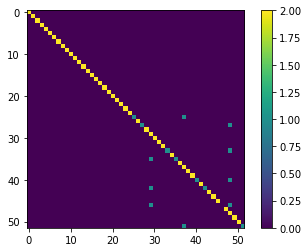

In [63]:
y_pred = grid.best_estimator_.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
plt.imshow(conf_mat, interpolation='nearest')
plt.colorbar()
accuracy = np.count_nonzero(y_pred == y_test) / len (y_test)
print("Best score : ", accuracy)

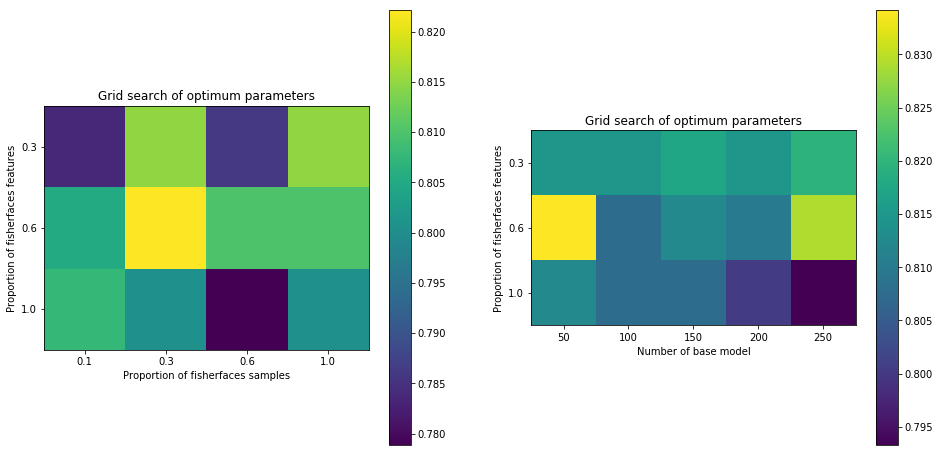

In [64]:
mean_scores = np.array(grid.cv_results_['mean_test_score'])
mean_scores = mean_scores.reshape(len(N_FEATURES_OPTIONS_LDA), len(N_FEATURES_OPTIONS_PCA), 
                                  len(MAX_FEATURES), len(MAX_SAMPLES), len(N_BASE_MODELS))
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(mean_scores[0,0,:,:,N_BASE_MODELS.index(200)], interpolation='nearest')
plt.title("Grid search of optimum parameters")
plt.xlabel('Proportion of fisherfaces samples')
plt.ylabel('Proportion of fisherfaces features')
plt.xticks(range(len(MAX_SAMPLES)), MAX_SAMPLES)
plt.yticks(range(len(MAX_FEATURES)), MAX_FEATURES)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(mean_scores[0,0,:,3,:], interpolation='nearest')
plt.title("Grid search of optimum parameters")
plt.xlabel('Number of base model')
plt.ylabel('Proportion of fisherfaces features')
plt.xticks(range(len(N_BASE_MODELS)), N_BASE_MODELS)
plt.yticks(range(len(MAX_FEATURES)), MAX_FEATURES)
plt.colorbar()

In [65]:
scores = []
for i in range(len(y_test)):
    scores.append(grid.best_estimator_.predict_proba(X_test)[i, y_test[i]-1])
print("Mean single model accuracy : ", np.mean(scores))

Mean single model accuracy :  0.7467307692307692


# PCA-LDA Ensemble with high randomness (i.e. PCA and LDA computed locally but their M are fixed)

In [5]:
pipe = Pipeline([
    ('reduce_dim_PCA', PCA()),
    ('reduce_dim_LDA', LinearDiscriminantAnalysis()),
    ('classify', KNeighborsClassifier(n_neighbors=1))
])

N_FEATURES_OPTIONS_PCA = [100]
N_FEATURES_OPTIONS_LDA = [50]
MAX_FEATURES = [0.04, 0.05, 0.06]
MAX_SAMPLES = [0.6, 0.8, 1.0]
N_BASE_MODELS = [300, 350, 400]

param_grid = [
    {
        'base_estimator__reduce_dim_PCA__n_components': N_FEATURES_OPTIONS_PCA,
        'base_estimator__reduce_dim_LDA__n_components': N_FEATURES_OPTIONS_LDA,
        'n_estimators': N_BASE_MODELS,
        'max_features': MAX_FEATURES,
        'max_samples': MAX_SAMPLES,
    }
]
bag = BaggingClassifier(base_estimator=pipe)
grid = GridSearchCV(bag, cv=5, n_jobs=1, param_grid=param_grid)
grid.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=BaggingClassifier(base_estimator=Pipeline(memory=None,
     steps=[('reduce_dim_PCA', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('reduce_dim_LDA', LinearDiscriminantAnalysis(n_components=None, priors=None, shri...stimators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid=[{'base_estimator__reduce_dim_PCA__n_components': [100], 'base_estimator__reduce_dim_LDA__n_components': [50], 'n_estimators': [300, 350, 400], 'max_features': [0.04, 0.05, 0.06], 'max_samples': [0.6, 0.8, 1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [6]:
grid.best_params_

{'base_estimator__reduce_dim_LDA__n_components': 50,
 'base_estimator__reduce_dim_PCA__n_components': 100,
 'max_features': 0.04,
 'max_samples': 1.0,
 'n_estimators': 350}

Best score :  0.9807692307692307


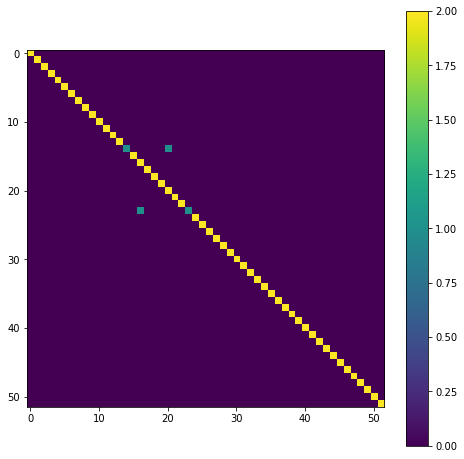

In [7]:
y_pred = grid.best_estimator_.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
plt.imshow(conf_mat, interpolation='nearest')
plt.colorbar()
accuracy = np.count_nonzero(y_pred == y_test) / len (y_test)
print("Best score : ", accuracy)

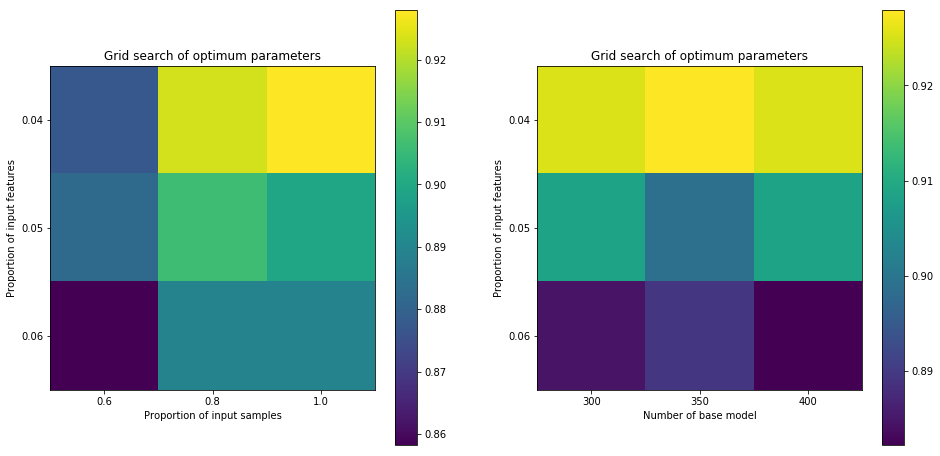

In [10]:
mean_scores = np.array(grid.cv_results_['mean_test_score'])
mean_scores = mean_scores.reshape(len(N_FEATURES_OPTIONS_LDA), len(N_FEATURES_OPTIONS_PCA), 
                                  len(MAX_FEATURES), len(MAX_SAMPLES), len(N_BASE_MODELS))
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(mean_scores[0,0,:,:,N_BASE_MODELS.index(350)], interpolation='nearest')
plt.title("Grid search of optimum parameters")
plt.xlabel('Proportion of input samples')
plt.ylabel('Proportion of input features')
plt.xticks(range(len(MAX_SAMPLES)), MAX_SAMPLES)
plt.yticks(range(len(MAX_FEATURES)), MAX_FEATURES)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(mean_scores[0,0,:,2,:], interpolation='nearest')
plt.title("Grid search of optimum parameters")
plt.xlabel('Number of base model')
plt.ylabel('Proportion of input features')
plt.xticks(range(len(N_BASE_MODELS)), N_BASE_MODELS)
plt.yticks(range(len(MAX_FEATURES)), MAX_FEATURES)
plt.colorbar()

In [9]:
scores = []
for i in range(len(y_test)):
    scores.append(grid.best_estimator_.predict_proba(X_test)[i, y_test[i]-1])
print("Mean single model accuracy : ", np.mean(scores))

Mean single model accuracy :  0.654532967032967
